In [1]:
import glob
import numpy as np
import tensorflow as tf
import gpflow

from hapi import EnvironmentDependency_Intensity, PYTIPS2017, molecularMass, pcqsdhc

import matplotlib.pyplot as plt

HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


# Read in some data

In [2]:
dat_files = glob.glob('/Users/jim2/CCI/MATS/MATS/MATS/Examples/A-Band - Experimental Spectra/*forfit.csv')
dat_files

['/Users/jim2/CCI/MATS/MATS/MATS/Examples/A-Band - Experimental Spectra/190513_2per_82_forfit.csv',
 '/Users/jim2/CCI/MATS/MATS/MATS/Examples/A-Band - Experimental Spectra/190514_2per_126_forfit.csv',
 '/Users/jim2/CCI/MATS/MATS/MATS/Examples/A-Band - Experimental Spectra/190510_2per_43_forfit.csv',
 '/Users/jim2/CCI/MATS/MATS/MATS/Examples/A-Band - Experimental Spectra/190510_2per_55_forfit.csv']

In [3]:
dat = [np.loadtxt(f, delimiter=',', skiprows=1) for f in dat_files]

In [4]:
x = [d[:, [3, 10, 11]] for d in dat]
for d in x:
    d[:, 0] *= (10**6) / 29979245800
    d[:, 1] += 273.15
    d[:, 2] /= 760.0

y = [d[:, 9] for d in dat]

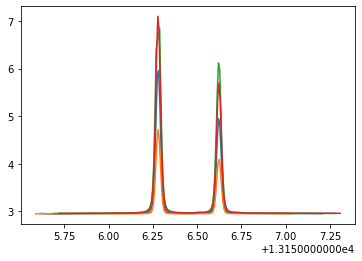

In [5]:
fig, ax = plt.subplots()
for i in range(len(x)):
    ax.plot(x[i][:, 0], y[i])
plt.show()

# Define our lineshape model

In [6]:
# ------------------ complex probability function -----------------------
def cpf3(X, Y):
    # define static data
    zone = np.complex128(1.0e0 + 0.0e0j)
    zi = np.complex128(0.0e0 + 1.0e0j)
    tt = np.float64([0.5e0,1.5e0,2.5e0,3.5e0,4.5e0,5.5e0,6.5e0,7.5e0,8.5e0,9.5e0,10.5e0,11.5e0,12.5e0,13.5e0,14.5e0])
    pipwoeronehalf = np.float64(0.564189583547756e0)

    zm1 = zone/tf.complex(X, Y) # maybe redundant
    zm2 = zm1**2
    zsum = zone
    zterm = zone

    for tt_i in tt:
        zterm *= zm2*tt_i
        zsum += zterm
    
    zsum *= zi*zm1*pipwoeronehalf
    
    return zsum

# ------------------ Schreier CPF ------------------------

# "Optimized implementations of rational approximations 
#  for the Voigt and complex error function".
# Franz Schreier. JQSRT 112 (2011) 1010-10250
# doi:10.1016/j.jqsrt.2010.12.010
def cef(x,y,N):
    # Computes the function w(z) = exp(-zA2) erfc(-iz) using a rational
    # series with N terms. It is assumed that Im(z) > 0 or Im(z) = 0.
    z = tf.complex(x, y)
    M = 2*N; M2 = 2*M; k = np.arange(-M+1,M) #'; # M2 = no. of sampling points.
    L = np.sqrt(N/np.sqrt(2)); # Optimal choice of L.
    theta = k*np.pi/M; t = L*np.tan(theta/2); # Variables theta and t.
    #f = exp(-t.A2)*(LA2+t.A2); f = [0; f]; # Function to be transformed.
    f = np.zeros(len(t)+1); f[0] = 0
    f[1:] = np.exp(-t**2)*(L**2+t**2)
    #f = insert(exp(-t**2)*(L**2+t**2),0,0)
    a = np.real(np.fft.fft(np.fft.fftshift(f)))/M2; # Coefficients of transform.
    a = np.flipud(a[1:N+1]); # Reorder coefficients.
    Z = (L+1.0j*z)/(L-1.0j*z)
    p = tf.math.polyval([tf.cast(val, tf.complex128) for val in a.tolist()], Z); # Polynomial evaluation.
    #Not sure if above line will work with Tensorflow...
    #Need to check because may fail quietly, i.e. break gradient without throwing error
    #If can figure out what this whole function is supposed to be doing, though, may be able to just
    #directly return w(z)... just need to know what zA2 and iz are...
    #Hopefully using tf.math.polyval instead of np.polyval will do the trick.
    w = 2*p/(L-1.0j*z)**2+(1/np.sqrt(np.pi))/(L-1.0j*z); # Evaluate w(z).
    return w
# weideman24 by default    
#weideman24 = lambda x,y: cef(x,y,24)
#weideman = lambda x,y,n: cef(x,y,n)
def hum1_wei(x,y,n=24):
    """
    z = x+1j*y
    cerf = 1j*z/sqrt(pi)/(z**2-0.5)
    """
    mask = abs(x)+y<15.0
    t = tf.complex(y, -x)
    #cerf_false = 1/np.sqrt(np.pi)*t/(0.5+t**2)
    #if np.any(mask):
    #    w24 = weideman(x[mask],y[mask],n)
    #    cerf = tf.dynamics_stitch([np.arange(x.shape[0])[~mask], np.arange(x.shape[0])[mask]],
    #                              [cerf_false[~mask], w24])
    #else:
    #    cerf = cerf_false
    #Above is fancy, but seems like below should just work...
    #Because in original, output of weideman() is same length as input, which is x and y where mask is True
    #So first N values of output should be weideman() of all x and y then with mask applied
    #For efficiency, still check for any being True
    if tf.reduce_any(mask):
        cerf = tf.where(mask, cef(x, y, n), 1/np.sqrt(np.pi)*t/(0.5+t**2))
    else:
        cerf = 1/np.sqrt(np.pi)*t/(0.5+t**2)
    return cerf

# ------------------ Hartmann-Tran Profile (HTP) ------------------------
# Made compatible with Tensorflow
def tf_pcqsdhc(sg0,GamD,Gam0,Gam2,Shift0,Shift2,anuVC,eta,sg):
    #-------------------------------------------------
    #      "pCqSDHC": partially-Correlated quadratic-Speed-Dependent Hard-Collision
    #      Subroutine to Compute the complex normalized spectral shape of an 
    #      isolated line by the pCqSDHC model
    #
    #      Reference:
    #      H. Tran, N.H. Ngo, J.-M. Hartmann.
    #      Efficient computation of some speed-dependent isolated line profiles.
    #      JQSRT, Volume 129, November 2013, Pages 199–203
    #      http://dx.doi.org/10.1016/j.jqsrt.2013.06.015
    #
    #      Input/Output Parameters of Routine (Arguments or Common)
    #      ---------------------------------
    #      T          : Temperature in Kelvin (Input).
    #      amM1       : Molar mass of the absorber in g/mol(Input).
    #      sg0        : Unperturbed line position in cm-1 (Input).
    #      GamD       : Doppler HWHM in cm-1 (Input)
    #      Gam0       : Speed-averaged line-width in cm-1 (Input).       
    #      Gam2       : Speed dependence of the line-width in cm-1 (Input).
    #      anuVC      : Velocity-changing frequency in cm-1 (Input).
    #      eta        : Correlation parameter, No unit (Input).
    #      Shift0     : Speed-averaged line-shift in cm-1 (Input).
    #      Shift2     : Speed dependence of the line-shift in cm-1 (Input)       
    #      sg         : Current WaveNumber of the Computation in cm-1 (Input).
    #
    #      Output Quantities (through Common Statements)
    #      -----------------
    #      LS_pCqSDHC_R: Real part of the normalized spectral shape (cm)
    #      LS_pCqSDHC_I: Imaginary part of the normalized spectral shape (cm)
    #
    #      Called Routines: 'CPF'      (Complex Probability Function)
    #      ---------------  'CPF3'      (Complex Probability Function for the region 3)
    #
    #      Called By: Main Program
    #      ---------
    #
    #     Double Precision Version
    #
    #-------------------------------------------------
    
    # sg is the only vector argument which is passed to function
    # Just make sure it's a vector
    sg = tf.constant(sg)
    
    #With Tensorflow, can't assign values within tensors, so must stitch together at end
    #number_of_points = sg.shape[0]
    #Aterm_GLOBAL = np.zeros(number_of_points, dtype=tf.complex128)
    #Bterm_GLOBAL = np.zeros(number_of_points, dtype=tf.complex128)
    
    #Multiplying by tensor of ones to make sure shape is right even if just provide scalars as parameters
    cte = tf.ones_like(sg, dtype=tf.complex128) * np.sqrt(np.log(2.0e0))/tf.cast(GamD, tf.complex128)
    rpi = np.sqrt(np.pi)

    c0 = tf.ones_like(sg, dtype=tf.complex128) * tf.complex(Gam0, Shift0)
    c2 = tf.ones_like(sg, dtype=tf.complex128) * tf.complex(Gam2, Shift2)
    c0t = tf.ones_like(sg, dtype=tf.complex128) * (1.0e0 - tf.cast(eta, tf.complex128)) * (c0 - 1.5e0 * c2) + tf.cast(anuVC, tf.complex128)
    c2t = tf.ones_like(sg, dtype=tf.complex128) * (1.0e0 - tf.cast(eta, tf.complex128)) * c2
        
    #In Tensorflow cannot do dynamic assignment, so keep track of indices and merge together at end
    Aterm_PART1 = tf.constant([], dtype=tf.complex128)
    Bterm_PART1 = tf.constant([], dtype=tf.complex128)
    merge_inds_PART1 = tf.constant([], dtype=tf.int32)
    Aterm_PART2 = tf.constant([], dtype=tf.complex128)
    Bterm_PART2 = tf.constant([], dtype=tf.complex128)
    merge_inds_PART2 = tf.constant([], dtype=tf.int32)
    Aterm_PART3 = tf.constant([], dtype=tf.complex128)
    Bterm_PART3 = tf.constant([], dtype=tf.complex128)
    merge_inds_PART3 = tf.constant([], dtype=tf.int32)
    Aterm_PART4 = tf.constant([], dtype=tf.complex128)
    Bterm_PART4 = tf.constant([], dtype=tf.complex128)
    merge_inds_PART4 = tf.constant([], dtype=tf.int32)
    
    # PART1
    index_PART1 = (abs(c2t) == 0.0e0)
    if tf.reduce_any(index_PART1):
        #print('Executing Part 1')
        Z1 = ((tf.complex(tf.zeros_like(sg), sg0 - sg) + c0t) * cte)[index_PART1]
        xZ1 = -tf.math.imag(Z1)
        yZ1 = tf.math.real(Z1)
        W1 = hum1_wei(xZ1,yZ1)
        Aterm = rpi*cte[index_PART1]*(W1)
        index_Z1 = (abs(Z1) <= 4.0e3)
        index_NOT_Z1 = ~index_Z1
        #if tf.reduce_any(index_Z1):
        if tf.reduce_all(index_Z1):
            Bterm = rpi*cte[index_PART1]*((1.0e0 - Z1**2)*(W1) + Z1/rpi)
        #Original in hapi.py was another if statement... if any(index_NOT_Z1)
        #Unless index_Z1 is all true, that overwrites everything
        #Not sure if that is the intended behavior, but if it is, accomplish by changing above to if all(index_Z1)
        #and changing below to just else
        #if tf.reduce_any(index_NOT_Z1): 
        else:
            Bterm = cte[index_PART1]*(rpi*(W1) + 0.5e0/Z1 - 0.75e0/(Z1**3))
        merge_inds_PART1 = tf.range(sg.shape[0])[index_PART1]
        Aterm_PART1 = Aterm
        Bterm_PART1 = Bterm

    # PART2, PART3 AND PART4   (PART4 IS A MAIN PART)
    # X - vector, Y - scalar
    X = (tf.complex(tf.zeros_like(sg), sg0 - sg) + c0t) / c2t
    Y = (1.0e0 / ((2.0e0*cte*c2t))**2)
    csqrtY = tf.complex(Gam2, -Shift2) / (2.0e0*cte*(1.0e0-tf.cast(eta, tf.complex128)) * tf.cast(Gam2**2 + Shift2**2, tf.complex128))
        
    index_PART2 = ((abs(X) <= 3.0e-8 * abs(Y)) & ~index_PART1)
    index_PART3 = ((abs(Y) <= 1.0e-15 * abs(X)) & ~index_PART2 & ~index_PART1)
    index_PART4 = (~(index_PART2 | index_PART3) & ~index_PART1)
        
    # PART4
    if tf.reduce_any(index_PART4):
        #print('Executing Part 4')
        #X_TMP = X[index_PART4]
        Z1 = (tf.sqrt(X + Y) - csqrtY)[index_PART4]
        Z2 = Z1 + 2.0e0 * csqrtY[index_PART4]
        xZ1 = -tf.math.imag(Z1)
        yZ1 =  tf.math.real(Z1)
        xZ2 = -tf.math.imag(Z2)
        yZ2 =  tf.math.real(Z2)
        SZ1 = tf.sqrt(xZ1**2 + yZ1**2)
        SZ2 = tf.sqrt(xZ2**2 + yZ2**2)
        DSZ = tf.abs(SZ1 - SZ2)
        SZmx = tf.maximum(SZ1,SZ2)
        SZmn = tf.minimum(SZ1,SZ2)
        index_CPF3 = ((DSZ <= 1.0e0) & (SZmx > 8.0e0) & (SZmn <= 8.0e0))
        W1_PART4 = tf.where(index_CPF3, cpf3(xZ1, yZ1), hum1_wei(xZ1, yZ1))
        W2_PART4 = tf.where(index_CPF3, cpf3(xZ2, yZ2), hum1_wei(xZ2, yZ2))
        Aterm = rpi*cte[index_PART4]*((W1_PART4) - (W2_PART4))
        Bterm = (-1.0e0 +
                  rpi/(2.0e0*csqrtY[index_PART4])*(1.0e0 - Z1**2)*(W1_PART4)-
                  rpi/(2.0e0*csqrtY[index_PART4])*(1.0e0 - Z2**2)*(W2_PART4)) / c2t[index_PART4]
        merge_inds_PART4 = tf.range(sg.shape[0])[index_PART4]
        Aterm_PART4 = Aterm
        Bterm_PART4 = Bterm

    # PART2
    if tf.reduce_any(index_PART2):
        #print('Executing Part 2')
        #X_TMP = X[index_PART2]
        Z1 = ((tf.complex(tf.zeros_like(sg), sg0 - sg) + c0t) * cte)[index_PART2]
        Z2 = (tf.sqrt(X + Y) + csqrtY)[index_PART2]
        xZ1 = -tf.math.imag(Z1)
        yZ1 = tf.math.real(Z1)
        xZ2 = -tf.math.imag(Z2)
        yZ2 = tf.math.real(Z2)
        W1_PART2 = hum1_wei(xZ1,yZ1)
        W2_PART2 = hum1_wei(xZ2,yZ2) 
        Aterm = rpi*cte[index_PART2]*((W1_PART2) - (W2_PART2))
        Bterm = (-1.0e0 +
                  rpi/(2.0e0*csqrtY[index_PART2])*(1.0e0 - Z1**2)*(W1_PART2)-
                  rpi/(2.0e0*csqrtY[index_PART2])*(1.0e0 - Z2**2)*(W2_PART2)) / c2t[index_PART2]
        merge_inds_PART2 = tf.range(sg.shape[0])[index_PART2]
        Aterm_PART2 = Aterm
        Bterm_PART2 = Bterm
            
    # PART3
    if tf.reduce_any(index_PART3):
        #print('Executing Part 3')
        X_TMP = X[index_PART3]
        Z1 = tf.sqrt(X + Y)[index_PART3]
        xZ1 = -tf.math.imag(Z1)
        yZ1 = tf.math.real(Z1)
        W1_PART3 =  hum1_wei(xZ1,yZ1) 
        index_ABS = (tf.abs(tf.sqrt(X_TMP)) <= 4.0e3)
        Wb = hum1_wei(-tf.math.imag(tf.sqrt(X_TMP)), tf.math.real(tf.sqrt(X_TMP))) #Original just had X, not X_TMP, which would break below (multiplication by Wb)
        Aterm = tf.where(index_ABS,
                         (2.0e0*rpi/c2t[index_PART3])*(1.0e0/rpi - tf.sqrt(X_TMP)*(Wb)),
                         (1.0e0/c2t[index_PART3])*(1.0e0/X_TMP - 1.5e0/(X_TMP**2))
                        )
        Bterm = tf.where(index_ABS,
                         (1.0e0/c2t[index_PART3])*(-1.0e0+
                                      2.0e0*rpi*(1.0e0 - X_TMP-2.0e0*Y[index_PART3])*(1.0e0/rpi-tf.sqrt(X_TMP)*(Wb))+
                                      2.0e0*rpi*tf.sqrt(X_TMP + Y[index_PART3])*(W1_PART3)),
                         (1.0e0/c2t[index_PART3])*(-1.0e0 + (1.0e0 - X_TMP - 2.0e0*Y[index_PART3])*
                                      (1.0e0/X_TMP - 1.5e0/(X_TMP**2))+
                                      #2.0e0*rpi*sqrt(X_TMP + Y)*(W1)) #original, but would fail b/c W1 out of scope
                                      2.0e0*rpi*tf.sqrt(X_TMP + Y[index_PART3])*(W1_PART3))
                        )
        merge_inds_PART3 = tf.range(sg.shape[0])[index_PART3]
        Aterm_PART3 = Aterm
        Bterm_PART3 = Bterm
    
    Aterm_GLOBAL = tf.dynamic_stitch([merge_inds_PART1, merge_inds_PART2, merge_inds_PART3, merge_inds_PART4],
                                     [Aterm_PART1, Aterm_PART2, Aterm_PART3, Aterm_PART4])
    Bterm_GLOBAL = tf.dynamic_stitch([merge_inds_PART1, merge_inds_PART2, merge_inds_PART3, merge_inds_PART4],
                                     [Bterm_PART1, Bterm_PART2, Bterm_PART3, Bterm_PART4])
            
    # common part
    LS_pCqSDHC = (1.0e0/np.pi) * (Aterm_GLOBAL / (1.0e0 - (tf.cast(anuVC, tf.complex128)-tf.cast(eta, tf.complex128)*(c0-1.5e0*c2))*Aterm_GLOBAL + tf.cast(eta, tf.complex128)*c2*Bterm_GLOBAL))
    #LS_pCqSDHC = tf.reshape(LS_pCqSDHC, (-1, 1))
    return tf.math.real(LS_pCqSDHC), tf.math.imag(LS_pCqSDHC)


In [215]:
#This recreates HTP_from_DF_select() for a single spectra
#It does NOT mix spectra, including multiple peaks, so what's in below, will remove one peak when fitting

class LineShape(gpflow.mean_functions.MeanFunction):
    
    def __init__(self, molec_id, iso,
                 nu=1.0,
                 sw=1.0,
                 sw_scale_fac=1e-26,
                 elower=1.0,
                 gamma0=0.02, n_gamma0=0.63,
                 delta0=-0.01, n_delta0=5e-05,
                 sd_gamma=0.1, n_gamma2=0.63,
                 sd_delta=0.0, n_delta2=0.0,
                 nuVC=0.0, n_nuVC=1.0,
                 eta=0.0,
                 y=0.0,
                 mole_frac=0.01949):
        #Molecular of interest
        self.molec_id = molec_id
        self.iso = iso
        self.nu = gpflow.Parameter(nu, dtype=tf.float64, name='nu')
        self.sw = gpflow.Parameter(sw, dtype=tf.float64, name='sw')
        self.sw_scale_fac = sw_scale_fac
        self.elower = gpflow.Parameter(elower, dtype=tf.float64, name='elower')
        #Diluent - defaults set to match air (or what I think is air)
        self.gamma0 = gpflow.Parameter(gamma0, dtype=tf.float64, name='gamma0')
        self.n_gamma0 = gpflow.Parameter(n_gamma0, dtype=tf.float64, name='n_gamma0', trainable=False)
        self.delta0 = gpflow.Parameter(delta0, dtype=tf.float64, name='delta0')
        self.n_delta0 = gpflow.Parameter(n_delta0, dtype=tf.float64, name='n_delta0', trainable=False)
        self.sd_gamma = gpflow.Parameter(sd_gamma, dtype=tf.float64, name='sd_gamma')
        self.n_gamma2 = gpflow.Parameter(n_gamma2, dtype=tf.float64, name='n_gamma2', trainable=False)
        self.sd_delta = gpflow.Parameter(sd_delta, dtype=tf.float64, name='sd_delta')
        self.n_delta2 = gpflow.Parameter(n_delta2, dtype=tf.float64, name='n_delta2', trainable=False)
        self.nuVC = gpflow.Parameter(nuVC, dtype=tf.float64, name='nuVC')
        self.n_nuVC = gpflow.Parameter(n_nuVC, dtype=tf.float64, name='n_nuVC', trainable=False)
        self.eta = gpflow.Parameter(eta, dtype=tf.float64, name='eta')
        self.y = gpflow.Parameter(y, dtype=tf.float64, name='y')
        #Other stuff
        self.Tref = 296.0
        self.Pref = 1.0
        self.mole_frac = mole_frac #Not sure where this comes in for the original MATS code (or natural abundance), but need it for good fits

    def get_params_at_TP(self, T, P):
        mass = molecularMass(self.molec_id, self.iso) * 1.66053873e-27 * 1000
        gammaD = np.sqrt(2*1.380648813E-16*T*np.log(2)/mass/2.99792458e10**2)*self.nu
        gamma0 = self.gamma0*(P/self.Pref)*((self.Tref/T)**self.n_gamma0)
        shift0 = (self.delta0 + self.n_delta0*(T-self.Tref))*(P/self.Pref)
        gamma2 = self.sd_gamma*self.gamma0*(P/self.Pref)*((self.Tref/T)**self.n_gamma2)
        shift2 = (self.sd_delta*self.delta0 + self.n_delta2*(T-self.Tref))*(P/self.Pref)
        nuVC = self.nuVC*(P/self.Pref)*((self.Tref/T)**self.n_nuVC)
        eta = self.eta        
        return(gammaD, gamma0, gamma2, shift0, shift2, nuVC, eta)
    
    def environmentdependency_intensity(self, T):
        sigmaT = np.array([PYTIPS2017(self.molec_id, self.iso, tval) for tval in T])
        sigmaTref = PYTIPS2017(self.molec_id, self.iso, self.Tref)
        #Taken from hapi.py and made compatible with tensorflow
        const = np.float64(1.4388028496642257)
        ch = tf.exp(-const*self.elower/T)*(1-tf.exp(-const*self.nu/T))
        zn = tf.exp(-const*self.elower/self.Tref)*(1-tf.exp(-const*self.nu/self.Tref))
        LineIntensity = self.sw_scale_fac*self.sw*sigmaTref/sigmaT*ch/zn
        return LineIntensity
    
    def __call__(self, xTP):
        #First column is x, next is T, last is P
        xTP = np.array(xTP, dtype=np.float64)
        x = xTP[:, 0]
        T = xTP[:, 1]
        P = xTP[:, 2]
        
        mol_dens = (P/9.869233e-7)/(1.380648813E-16*T)
        line_intensity = self.environmentdependency_intensity(T)
        y = self.y*(P/self.Pref)
        
        params = self.get_params_at_TP(T, P)
        
        vals_real, vals_imag = tf_pcqsdhc(self.nu, *params, x)
        out = mol_dens * self.mole_frac * line_intensity * (vals_real + y*vals_imag)
        out *= 1e+06 #Make ppm/cm instead of just 1/cm
        out = tf.reshape(out, (-1, 1))
        return out


#Same as above, but allows multiple lines, so multiple peaks
#All inputs should be a list and for convenience, takes keyword arguments dictionary
#(and uses to overwrite defaults instead of specifying all default kwargs)
#Also added in option for etalon arguments
#Should have one etalon for each lineshape if choose to include
class LineShapeMulti(gpflow.mean_functions.MeanFunction):
    
    def __init__(self, molec_id, iso, **kwargs):
        
        #Molecules/lines of interest
        self.molec_id = molec_id
        self.iso = iso
        self.n_lines = len(self.molec_id)
        
        #Defaults, think diluent defaults are right for air?
        #Trainable parameters during optimization
        param_dict = {'nu':1.0*np.ones(self.n_lines),
                      'sw':1.0*np.ones(self.n_lines),
                      'elower':1.0*np.ones(self.n_lines),
                      'gamma0':0.02*np.ones(self.n_lines),
                      'delta0':-0.01*np.ones(self.n_lines),
                      'sd_gamma':0.1*np.ones(self.n_lines),
                      'sd_delta':0.0*np.ones(self.n_lines),
                      'nuVC':0.0*np.ones(self.n_lines),
                      'eta':0.0*np.ones(self.n_lines),
                      'y':0.0*np.ones(self.n_lines)
                     }
        #Non-trainable with MATS (cannot vary)
        non_param_dict = {'elower':1.0*np.ones(self.n_lines),
                          'sw_scale_fac':(1e-26)*np.ones(self.n_lines),
                          'n_gamma0':0.63*np.ones(self.n_lines),
                          'n_delta0':(5e-05)*np.ones(self.n_lines),
                          'n_gamma2':0.63*np.ones(self.n_lines),
                          'n_delta2':0.0*np.ones(self.n_lines),
                          'n_nuVC':1.0*np.ones(self.n_lines),
                          'mole_frac':1.0*np.ones(self.n_lines), #Not sure where this comes in for the original MATS code (or natural abundance), but need it for good fits
                          'etalons':np.array([0.0, 1.0, 0.0]*self.n_lines), #Amplitutde, frequency, phase
                         }
        #Update with passed keyword arguments
        for param_name in kwargs.keys():
            if param_name in param_dict.keys():
                param_dict[param_name] = kwargs[param_name]
            elif param_name in non_param_dict.keys():
                non_param_dict[param_name] = kwargs[param_name]
            else:
                raise ValueError("Argument %s not recognized."%param_name)
        
        #Set all parameters that are trainable
        for key, val in param_dict.items():
            setattr(self, key, gpflow.Parameter(val, dtype=tf.float64, name=key, trainable=True))
        
        #Set all other parameters
        for key, val in non_param_dict.items():
            setattr(self, key, val)
        
        #Other stuff - seems to be constant and not change
        self.Tref = 296.0
        self.Pref = 1.0

    def get_params_at_TP(self, T, P, index):
        mass = molecularMass(self.molec_id[index], self.iso[index]) * 1.66053873e-27 * 1000
        gammaD = np.sqrt(2*1.380648813E-16*T*np.log(2)/mass/2.99792458e10**2)*self.nu[index]
        gamma0 = self.gamma0[index]*(P/self.Pref)*((self.Tref/T)**self.n_gamma0[index])
        shift0 = (self.delta0[index] + self.n_delta0[index]*(T-self.Tref))*(P/self.Pref)
        gamma2 = self.sd_gamma[index]*self.gamma0[index]*(P/self.Pref)*((self.Tref/T)**self.n_gamma2[index])
        shift2 = (self.sd_delta[index]*self.delta0[index] + self.n_delta2[index]*(T-self.Tref))*(P/self.Pref)
        nuVC = self.nuVC[index]*(P/self.Pref)*((self.Tref/T)**self.n_nuVC[index])
        eta = self.eta[index]
        return(gammaD, gamma0, gamma2, shift0, shift2, nuVC, eta)
    
    def environmentdependency_intensity(self, T, index):
        sigmaT = np.array([PYTIPS2017(self.molec_id[index], self.iso[index], tval) for tval in T])
        sigmaTref = PYTIPS2017(self.molec_id[index], self.iso[index], self.Tref)
        #Taken from hapi.py and made compatible with tensorflow
        const = np.float64(1.4388028496642257)
        ch = tf.exp(-const*self.elower[index]/T)*(1-tf.exp(-const*self.nu[index]/T))
        zn = tf.exp(-const*self.elower[index]/self.Tref)*(1-tf.exp(-const*self.nu[index]/self.Tref))
        LineIntensity = self.sw_scale_fac[index]*self.sw[index]*sigmaTref/sigmaT*ch/zn
        return LineIntensity
    
    def calc_etalons(self, wavenumbers):
        x = wavenumbers - np.min(wavenumbers)
        etalon_model = np.zeros(wavenumbers.shape)
        for eta in self.etalons:
            amp, freq, phase = (eta[0], eta[1], eta[2])
            etalon_model += amp * np.sin((2 * np.pi * freq) * x + phase)
        return etalon_model
    
    def __call__(self, xTP):
        #First column is x, next is T, last is P
        xTP = np.array(xTP, dtype=np.float64)
        x = xTP[:, 0]
        T = xTP[:, 1]
        P = xTP[:, 2]
        
        mol_dens = (P/9.869233e-7)/(1.380648813E-16*T)
        
        #Loop over all molecules/lines
        out = 0.0
        for i in range(self.n_lines):
            line_intensity = self.environmentdependency_intensity(T, i)
            y = self.y[i]*(P/self.Pref)
            params = self.get_params_at_TP(T, P, i)
            vals_real, vals_imag = tf_pcqsdhc(self.nu[i], *params, x)
            this_out = mol_dens * self.mole_frac[i] * line_intensity * (vals_real + y*vals_imag)
            out = out + this_out*1e+06#Make ppm/cm instead of just 1/cm
        out = out + self.calc_etalons(x)
        out = tf.reshape(out, (-1, 1))
        return out


# Testing code converted from hapi.py

In [9]:
#Create a lineshape model just to collect parameters for testing
#Also makes sure have GPFlow parameters to test with
lineshape = LineShape(7, 1, nu=13156.28, sw=0.00013700000000000005, elower=343.75, sd_gamma=1e+16)

In [10]:
#By changing inputs, can check different "parts" of pcqsdhc, like part1, part2, part3, and part4
lineshape(np.array([[0.1, 2.97876013e+02, 4.60173207e-02],
                    [2.0, 2.97876013e+02, 4.60173207e-02],
                    [1.0, 2.0, 4.60173207e-02],
                    [2.0, 2.0, 4.60173207e-02]]))
#lineshape(x[0])

<tf.Tensor: shape=(4, 1), dtype=float64, numpy=
array([[-4.83517823e-022],
       [-4.83517823e-022],
       [-6.97289551e-126],
       [-6.97289551e-126]])>

In [11]:
#Compare output of original function in pcqsdhc to our tensorflow implementation
pcqsdhc(lineshape.nu.numpy(),
        *[p.numpy() for p in lineshape.get_params_at_TP(x[0][0, 1], x[0][0, 2])],
        x[0][:, 0])

(array([-1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.59051633e-14, -1.59051633e-14, -1.59051633e-14, -1.59051633e-14,
        -1.5

In [12]:
tf_pcqsdhc(lineshape.nu.numpy(),
           *[p.numpy() for p in lineshape.get_params_at_TP(x[0][0, 1], x[0][0, 2])],
           x[0][:, 0])

(<tf.Tensor: shape=(237,), dtype=float64, numpy=
 array([-1.59051639e-14, -1.59051639e-14, -1.59051639e-14, -1.59051639e-14,
        -1.59051639e-14, -1.59051639e-14, -1.59051639e-14, -1.59051639e-14,
        -1.59051639e-14, -1.59051639e-14, -1.59051639e-14, -1.59051639e-14,
        -1.59051639e-14, -1.59051639e-14, -1.59051639e-14, -1.59051639e-14,
        -1.59051639e-14, -1.59051639e-14, -1.59051639e-14, -1.59051639e-14,
        -1.59051639e-14, -1.59051639e-14, -1.59051639e-14, -1.59051639e-14,
        -1.59051639e-14, -1.59051639e-14, -1.59051639e-14, -1.59051639e-14,
        -1.59051639e-14, -1.59051639e-14, -1.59051639e-14, -1.59051639e-14,
        -1.59051639e-14, -1.59051639e-14, -1.59051639e-14, -1.59051639e-14,
        -1.59051639e-14, -1.59051639e-14, -1.59051639e-14, -1.59051639e-14,
        -1.59051639e-14, -1.59051639e-14, -1.59051639e-14, -1.59051639e-14,
        -1.59051639e-14, -1.59051639e-14, -1.59051639e-14, -1.59051639e-14,
        -1.59051639e-14, -1.59051639e-1

In [13]:
#Compare output for all functions we converted from hapi.py
from hapi import hum1_wei as hapi_hum1_wei
from hapi import cpf3 as hapi_cpf3

In [14]:
hum1_wei(tf.cast(np.array([1.0]), tf.float64), tf.cast(np.array([1.0]), tf.float64), 24)

<tf.Tensor: shape=(1,), dtype=complex128, numpy=array([0.30474421+0.20821894j])>

In [15]:
hapi_hum1_wei(np.array([1.0]), np.array([1.0]), 24)

(array([0.30474421]), array([0.20821894]))

In [16]:
cpf3(tf.cast([1.0], tf.float64), tf.cast([1.0], tf.float64))

<tf.Tensor: shape=(1,), dtype=complex128, numpy=array([-1813146.53894845+1374805.67620273j])>

In [17]:
hapi_cpf3(1.0, 1.0)

(array([-1813146.53894845]), array([1374805.67620273]))

In [18]:
#Now check if can compute gradients...
with tf.GradientTape() as tape:
    alpha = lineshape(x[0])
    grads = tape.gradient(alpha, lineshape.trainable_variables)
    print(grads)

(<tf.Tensor: shape=(), dtype=float64, numpy=-1.3346999786606265e-34>, <tf.Tensor: shape=(), dtype=float64, numpy=-3.508630489640357e-24>, <tf.Tensor: shape=(), dtype=float64, numpy=-2.6481536735324493e-33>, <tf.Tensor: shape=(), dtype=float64, numpy=5.729687828489807e-18>, <tf.Tensor: shape=(), dtype=float64, numpy=-2.9004295719667568e-33>, <tf.Tensor: shape=(), dtype=float64, numpy=-4.584487089467313e-34>, <tf.Tensor: shape=(), dtype=float64, numpy=-2.002050090383559e-36>, <tf.Tensor: shape=(), dtype=float64, numpy=1.1459375656979613e-35>, <tf.Tensor: shape=(), dtype=float64, numpy=-8.364507778817757e-16>, <tf.Tensor: shape=(), dtype=float64, numpy=1.8352570152310655e-21>)


# Example fitting with GPR model

In [19]:
#Test out actually fitting some parameters with a GPFlow model
lineshape = LineShape(7, 1, nu=13156.28, sw=4.799, elower=343.75, sw_scale_fac=1e-24,
                      delta0=-0.007967, n_delta0=2.4e-05,
                      n_gamma0=0.81, n_gamma2=0.81,
                      #gamma0=0.04487, sd_gamma=0.11240, #These are the optimized values of these parameters from MATS
                     )

#Will only optimize gamma0 and sd_gamma according to example
gpflow.set_trainable(lineshape.nu, False)
gpflow.set_trainable(lineshape.sw, False)
gpflow.set_trainable(lineshape.elower, False)
gpflow.set_trainable(lineshape.y, False)
gpflow.set_trainable(lineshape.eta, False)
gpflow.set_trainable(lineshape.sd_delta, False)
gpflow.set_trainable(lineshape.nuVC, False)
gpflow.set_trainable(lineshape.delta0, False)
print(lineshape.trainable_variables)

(<tf.Variable 'gamma0:0' shape=() dtype=float64, numpy=0.02>, <tf.Variable 'sd_gamma:0' shape=() dtype=float64, numpy=0.1>)


In [20]:
kern = gpflow.kernels.SquaredExponential(lengthscales=[1.0, 1.0, 1.0])

#Lineshape model defined above only handles a single peak, but the data has two peaks
#Just remove the upper peak, since in the above cell have defined parameters for the lower peak
test_x = x[0][:int(x[0].shape[0]/2), :]
test_y = y[0][:int(x[0].shape[0]/2)][:, None]

#Define our Gaussian process regression model
gpr = gpflow.models.GPR(data=(test_x, test_y), kernel=kern, mean_function=lineshape)

In [21]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.nu,Parameter,Identity,,False,(),float64,13156.28
GPR.mean_function.sw,Parameter,Identity,,False,(),float64,4.799
GPR.mean_function.elower,Parameter,Identity,,False,(),float64,343.75
GPR.mean_function.gamma0,Parameter,Identity,,True,(),float64,0.02
GPR.mean_function.n_gamma0,Parameter,Identity,,False,(),float64,0.81
GPR.mean_function.delta0,Parameter,Identity,,False,(),float64,-0.007967
GPR.mean_function.n_delta0,Parameter,Identity,,False,(),float64,2.4e-05
GPR.mean_function.sd_gamma,Parameter,Identity,,True,(),float64,0.1
GPR.mean_function.n_gamma2,Parameter,Identity,,False,(),float64,0.81
GPR.mean_function.sd_delta,Parameter,Identity,,False,(),float64,0.0


(118, 1)
(118, 1)


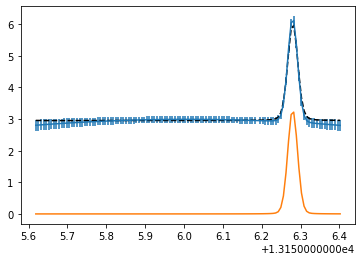

In [22]:
#Predictions before training
fig, ax = plt.subplots()

mean, var = gpr.predict_f(test_x)
print(mean.shape)

line = lineshape(test_x)
print(line.shape)

plt.errorbar(test_x[:, 0], mean.numpy(), yerr=np.sqrt(var.numpy().flatten()))
plt.plot(test_x[:, 0], line.numpy())
plt.plot(test_x[:, 0], test_y, 'k--')

plt.show()

In [23]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=10))

In [24]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.nu,Parameter,Identity,,False,(),float64,13156.28
GPR.mean_function.sw,Parameter,Identity,,False,(),float64,4.799
GPR.mean_function.elower,Parameter,Identity,,False,(),float64,343.75
GPR.mean_function.gamma0,Parameter,Identity,,True,(),float64,0.05918140750688596
GPR.mean_function.n_gamma0,Parameter,Identity,,False,(),float64,0.81
GPR.mean_function.delta0,Parameter,Identity,,False,(),float64,-0.007967
GPR.mean_function.n_delta0,Parameter,Identity,,False,(),float64,2.4e-05
GPR.mean_function.sd_gamma,Parameter,Identity,,True,(),float64,0.3627399099167588
GPR.mean_function.n_gamma2,Parameter,Identity,,False,(),float64,0.81
GPR.mean_function.sd_delta,Parameter,Identity,,False,(),float64,0.0


(118, 1)
(118, 1)


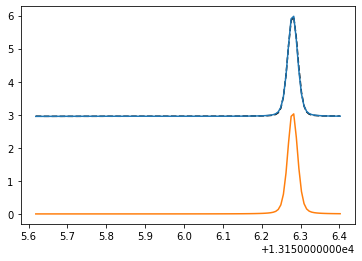

In [25]:
#And look at predictions from training
fig, ax = plt.subplots()

mean, var = gpr.predict_f(test_x)
print(mean.shape)

line = lineshape(test_x)
print(line.shape)

plt.errorbar(test_x[:, 0], mean.numpy(), yerr=np.sqrt(var.numpy().flatten()))
plt.plot(test_x[:, 0], line.numpy())
plt.plot(test_x[:, 0], test_y, 'k--')

plt.show()

# Multi-line fitting with VGP

In [8]:
#Now with both peaks!
#And at all pressures!
#And with different noise variance parameters for the different datasets! (see next cell)
#Test out actually fitting some parameters with a GPFlow model
lineshape = LineShapeMulti([7, 7], [1, 1],
                           nu=[13156.28, 13156.62],
                           sw=[4.799, 3.123],
                           elower=[343.75, 440.56],
                           sw_scale_fac=[1e-24, 1e-24],
                           mole_frac=[0.01949, 0.01949],
                           delta0=[-0.007967, -0.008546999999999999],
                           n_delta0=[2.4e-05, 2.8000000000000013e-05],
                           n_gamma0=[0.81, 0.8],
                           n_gamma2=[0.81, 0.8],
                           #gamma0=[0.04487, 0.04331], sd_gamma=[0.11240, 0.13064], #These are the optimized values of these parameters from MATS
                          )

#Will only optimize gamma0 and sd_gamma according to example
gpflow.set_trainable(lineshape.nu, False)
gpflow.set_trainable(lineshape.sw, False)
gpflow.set_trainable(lineshape.y, False)
gpflow.set_trainable(lineshape.eta, False)
gpflow.set_trainable(lineshape.sd_delta, False)
gpflow.set_trainable(lineshape.nuVC, False)
gpflow.set_trainable(lineshape.delta0, False)
print(lineshape.trainable_variables)

(<tf.Variable 'gamma0:0' shape=(2,) dtype=float64, numpy=array([0.02, 0.02])>, <tf.Variable 'sd_gamma:0' shape=(2,) dtype=float64, numpy=array([0.1, 0.1])>)


In [9]:
gpflow.config.set_default_jitter(1e-05)

kern = gpflow.kernels.SquaredExponential(lengthscales=[1.0, 1.0, 1.0])

switchedlike = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.Gaussian(variance=1.0) for i in range(len(y))])

test_x = np.vstack(x)
#Add column in y to indicate different likelihoods, i.e., different noise on different experimental datasets
test_y = np.vstack([np.vstack([y[i], np.ones_like(y[i])*i]).T for i in range(len(y))])
print(test_x.shape)
print(test_y.shape)

#Define our Gaussian process regression model
gpr = gpflow.models.VGP(data=(test_x, test_y),
                        kernel=kern,
                        likelihood=switchedlike,
                        mean_function=lineshape,
                        num_latent_gps=1)

#Above SHOULD allow for different noise variances on different experimental datasets
#But results in instability of model if don't set jitter a little larger
#Below fits any number of peaks with any number of datasets, but have same noise over all datasets
# test_x = np.vstack(x)
# test_y = np.vstack([y[i][:, None] for i in range(len(y))])
# print(test_x.shape)
# print(test_y.shape)

# gpr = gpflow.models.GPR(data=(test_x, test_y),
#                         kernel=kern,
#                         mean_function=lineshape,
#                         noise_variance=0.01)

(928, 3)
(928, 2)


In [10]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.nu,Parameter,Identity,,False,"(2,)",float64,[13156.28 13156.62]
VGP.mean_function.sw,Parameter,Identity,,False,"(2,)",float64,[4.799 3.123]
VGP.mean_function.gamma0,Parameter,Identity,,True,"(2,)",float64,[0.02 0.02]
VGP.mean_function.delta0,Parameter,Identity,,False,"(2,)",float64,[-0.007967 -0.008547]
VGP.mean_function.sd_gamma,Parameter,Identity,,True,"(2,)",float64,[0.1 0.1]
VGP.mean_function.sd_delta,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
VGP.mean_function.nuVC,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
VGP.mean_function.eta,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
VGP.mean_function.y,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0


In [33]:
gpflow.set_trainable(gpr.q_mu, False)
gpflow.set_trainable(gpr.q_sqrt, False)
gpr.q_sqrt.assign(gpr.q_sqrt.numpy()*2.0e-03)

<tf.Variable 'UnreadVariable' shape=(1, 431056) dtype=float64, numpy=array([[0.002, 0.   , 0.   , ..., 0.   , 0.   , 0.002]])>

In [41]:
gpflow.default_jitter()

1e-05

In [35]:
# #Train just the variational parameters
# natgrad = gpflow.optimizers.NaturalGradient(gamma=1.0)
# for _ in range(10):
#     jitter = 1.0 * gpflow.default_jitter()
#     try:
#         natgrad.minimize(gpr.training_loss, [(gpr.q_mu, gpr.q_sqrt)])
#     except tf.errors.InvalidArgumentError:
#         jitter = 10.0 * gpflow.default_jitter()
#         if jitter < 0.1:
#             print("Jitter is now %f"%jitter)
#             with gpflow.config.as_context(gpflow.config.Config(jitter=jitter)):
#                 natgrad.minimize(gpr.training_loss, [(gpr.q_mu, gpr.q_sqrt)])
#         else:
#             raise ValueError("Jitter increased to 0.1 or larger. Need to check data and model manually.")


Jitter is now 0.000010
Jitter is now 0.000010
Jitter is now 0.000010
Jitter is now 0.000010
Jitter is now 0.000010
Jitter is now 0.000010
Jitter is now 0.000010
Jitter is now 0.000010
Jitter is now 0.000010
Jitter is now 0.000010


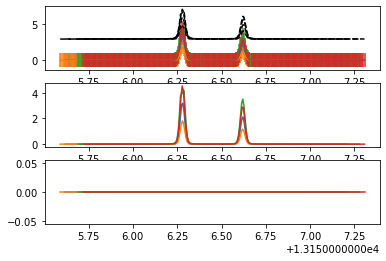

In [11]:
#Predictions before training
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(3)

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    line = lineshape(x[i])
    ax[0].errorbar(x[i][:, 0], mean.numpy(), yerr=np.sqrt(var.numpy().flatten()), color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--')
    ax[1].plot(x[i][:, 0], line.numpy(), color=colors[i])
    ax[2].plot(x[i][:, 0], mean.numpy()-line.numpy(), color=colors[i])

plt.show()

In [12]:
natgrad = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam = tf.optimizers.Adam()
gpflow.set_trainable(gpr.q_mu, False)
gpflow.set_trainable(gpr.q_sqrt, False)

for _ in range(100):
    natgrad.minimize(gpr.training_loss, [(gpr.q_mu, gpr.q_sqrt)])
    adam.minimize(gpr.training_loss, gpr.trainable_variables)

#Above is training if using a VGP to get different noise on different datasets
# opt = gpflow.optimizers.Scipy()
# opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=50))

In [13]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.nu,Parameter,Identity,,False,"(2,)",float64,[13156.28 13156.62]
VGP.mean_function.sw,Parameter,Identity,,False,"(2,)",float64,[4.799 3.123]
VGP.mean_function.gamma0,Parameter,Identity,,True,"(2,)",float64,[0.04438879 0.047454 ]
VGP.mean_function.delta0,Parameter,Identity,,False,"(2,)",float64,[-0.007967 -0.008547]
VGP.mean_function.sd_gamma,Parameter,Identity,,True,"(2,)",float64,[0.09867953 0.05775199]
VGP.mean_function.sd_delta,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
VGP.mean_function.nuVC,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
VGP.mean_function.eta,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
VGP.mean_function.y,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.018748867620755


<IPython.core.display.Javascript object>


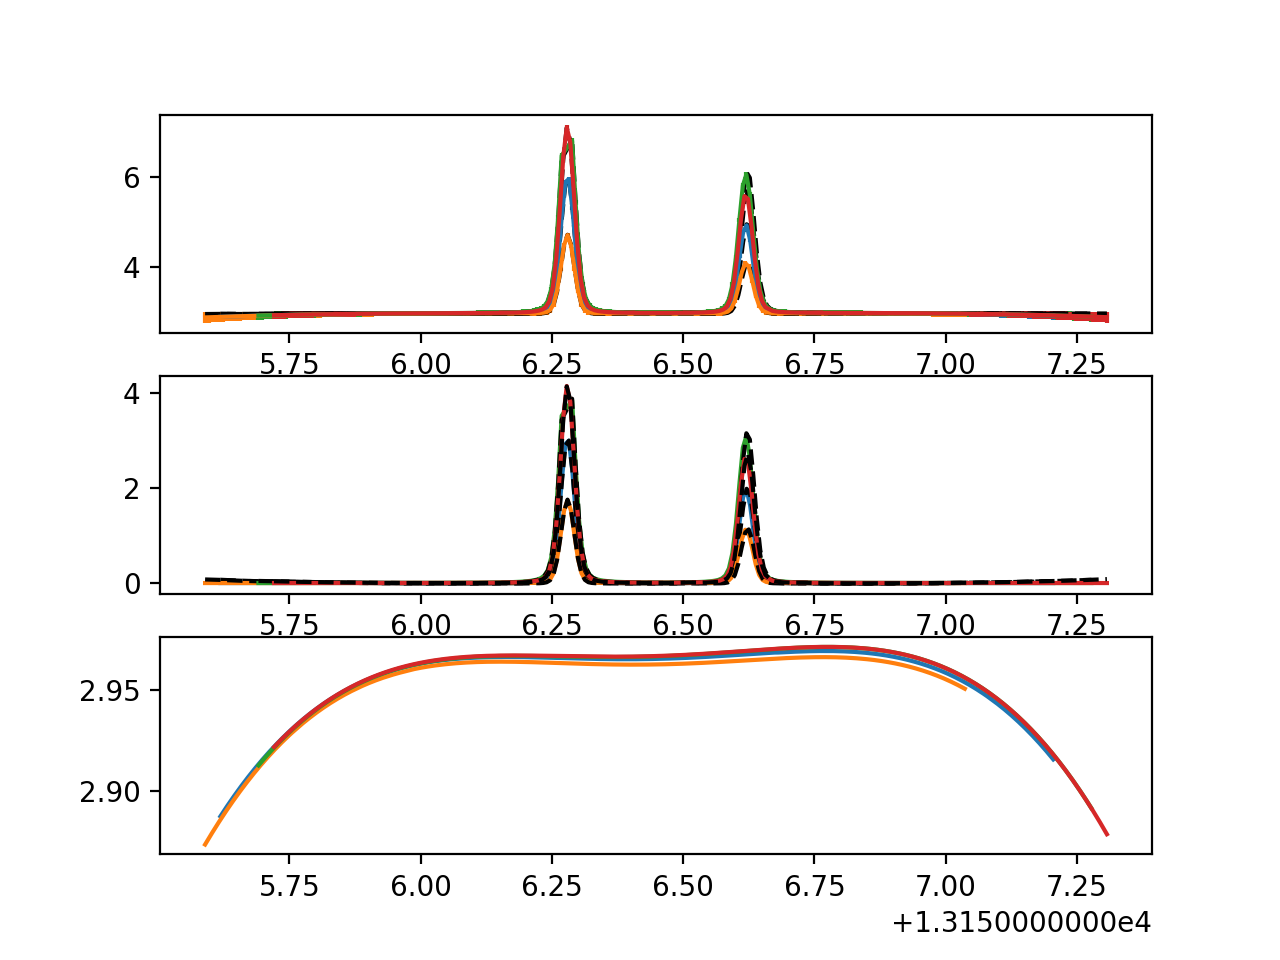

In [33]:
%matplotlib notebook

#And look at predictions from training
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(3)

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    mean = mean[:, 0].numpy()
    var = var[:, 0].numpy()
    line = lineshape(x[i]).numpy().flatten()
    ax[0].errorbar(x[i][:, 0], mean, yerr=np.sqrt(var), color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--')
    ax[1].plot(x[i][:, 0], line, color=colors[i])
    ax[1].plot(x[i][:, 0], y[i] - (mean - line), 'k--')
    ax[2].plot(x[i][:, 0], mean - line, color=colors[i])

plt.show()

<IPython.core.display.Javascript object>


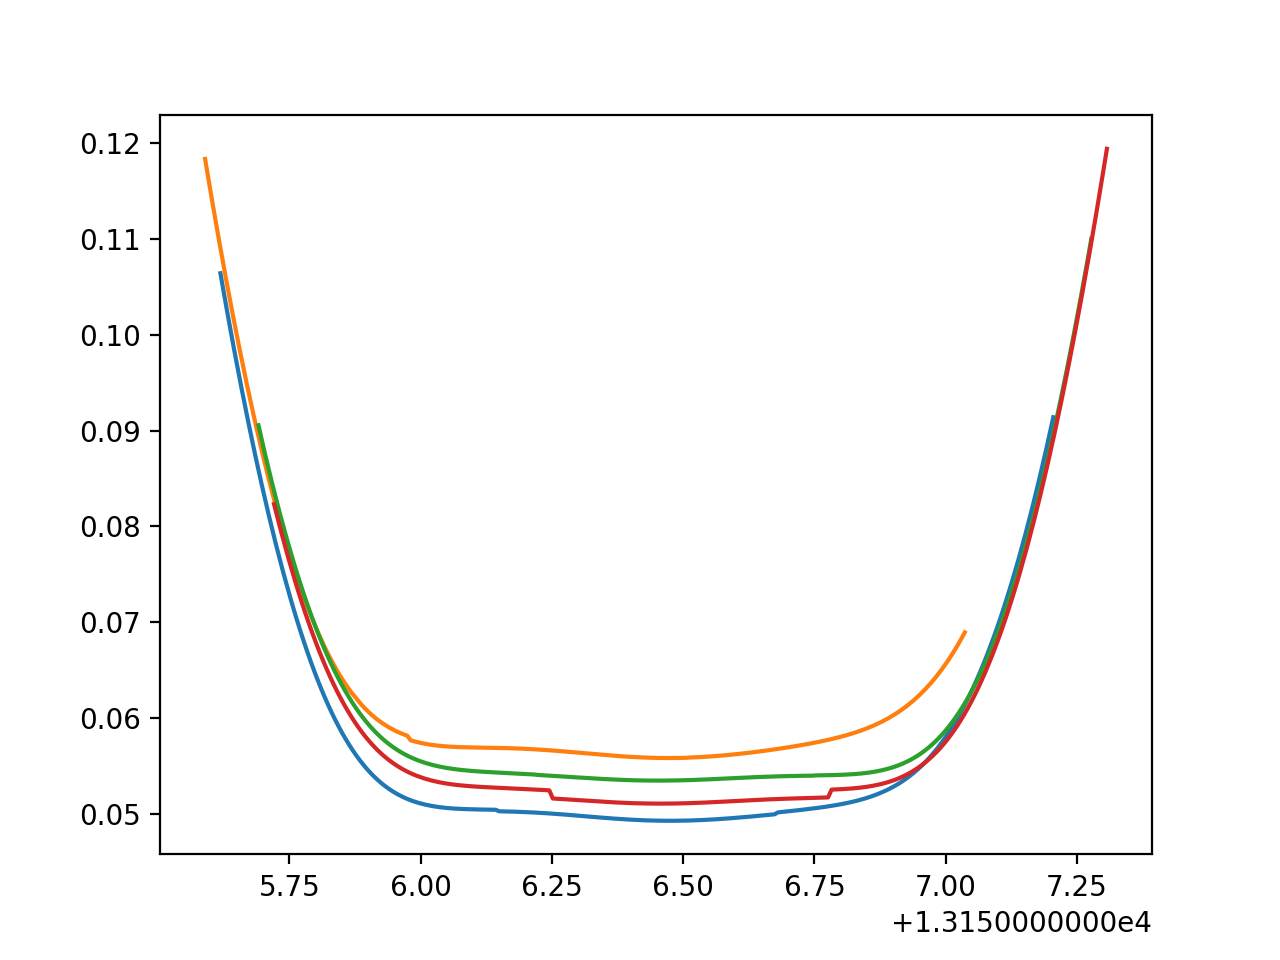

In [34]:
#Examine estimated uncertainty, including estimated noise in data
for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    std = np.sqrt(var[:, 0].numpy().flatten())
    plt.plot(x[i][:, 0], std)

plt.show()

Need to check, but guessing that the places where the uncertainty sharply drops are where the mean function actually produces something other than zero. The mean function does have a cutoff for the minimum intensity, but need to check if this coincides with the discontinuities.

In [28]:
#And if we want to, we can also plot this as a function of both wavenumber AND pressure
#Sort of done above, but above plotted at the input pressures
#We also have model for the uncertainty at unmeasured pressures
p_vals = np.linspace(np.min(test_x[:, 2]), np.max(test_x[:, 2]), 100)
x_vals = np.linspace(np.min(test_x[:, 0]), np.max(test_x[:, 0]), 500)
t_val = np.average(test_x[:, 1])
xtp_vals = []
for p in p_vals:
    xtp_vals.append(np.vstack([x_vals, np.ones_like(x_vals)*t_val, np.ones_like(x_vals)*p]).T)
xtp_vals = np.vstack(xtp_vals)
print(xtp_vals.shape)

(50000, 3)


In [29]:
#Reshape into 2D image
mean, var = gpr.predict_f(xtp_vals)
std = np.sqrt(var.numpy().flatten())
std = np.reshape(std, (x_vals.shape[0], -1))
print(std.shape)

(500, 100)


<IPython.core.display.Javascript object>


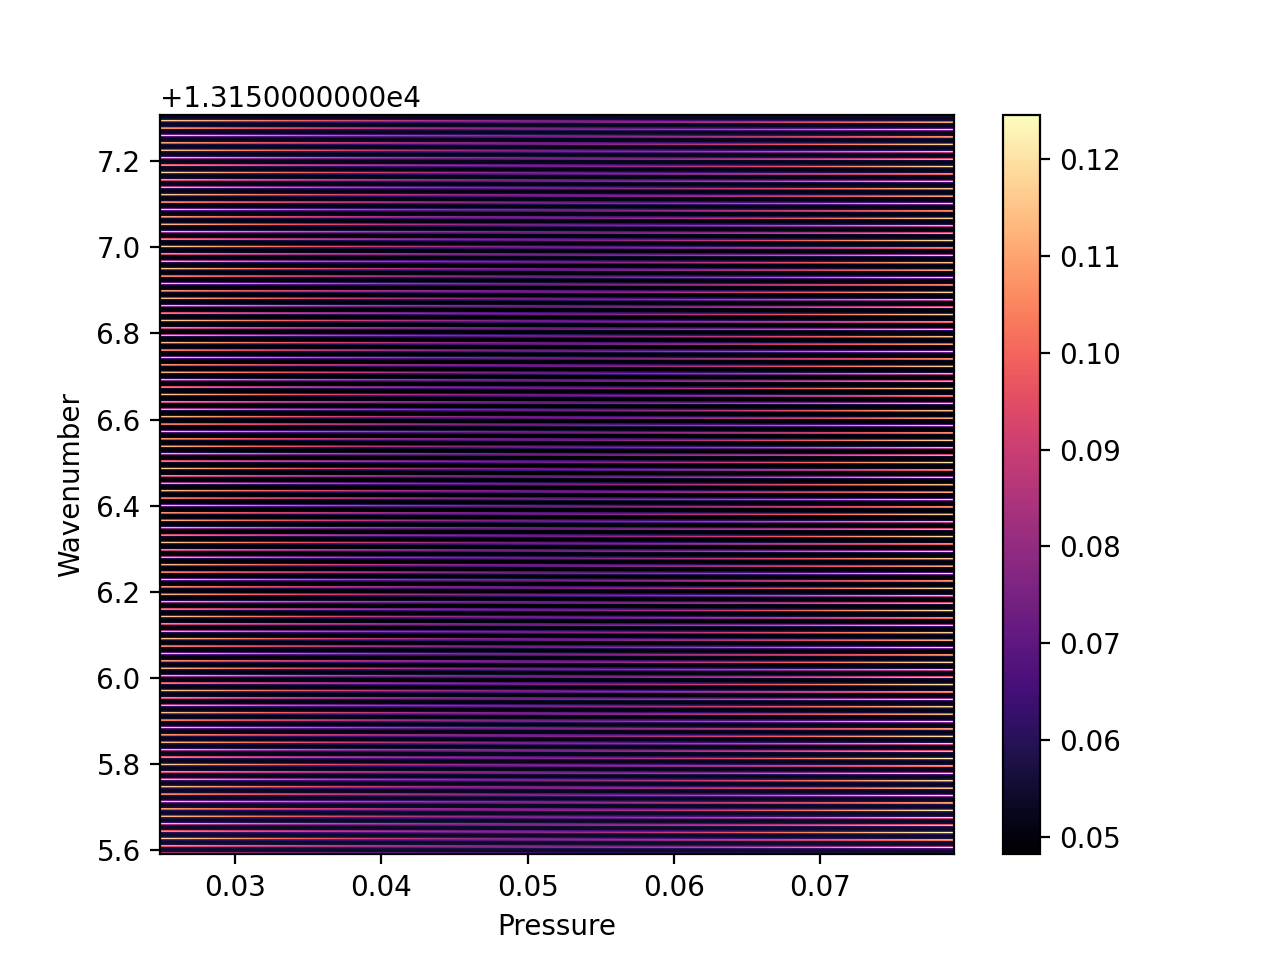

In [30]:
#And plot that image
%matplotlib notebook
im = plt.imshow(std, cmap='magma', aspect='auto', origin='lower',
                extent=(p_vals[0], p_vals[-1], x_vals[0], x_vals[-1]))
plt.colorbar(im)
plt.xlabel('Pressure')
plt.ylabel('Wavenumber')
plt.show()

<IPython.core.display.Javascript object>


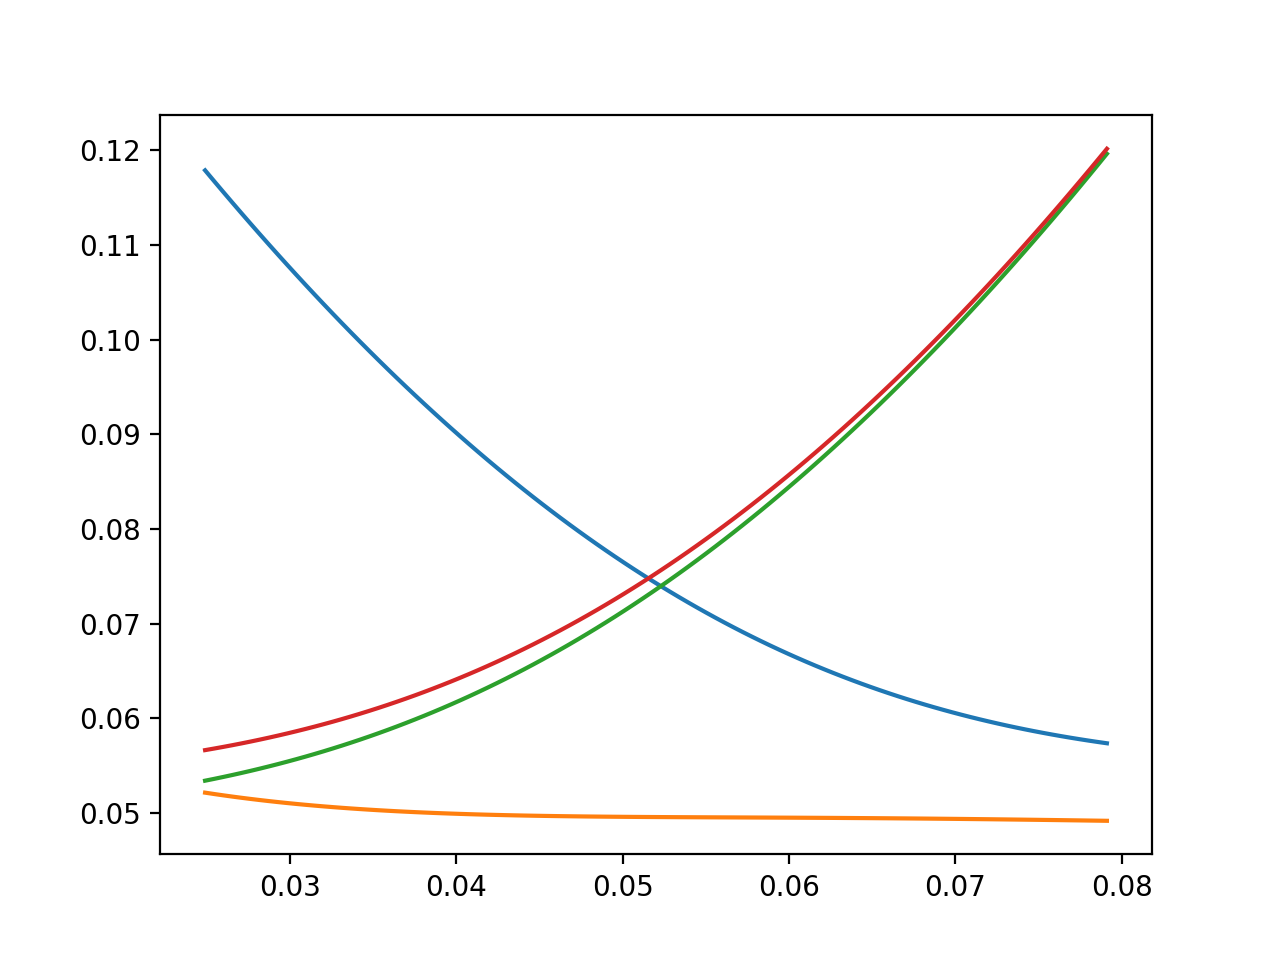

In [31]:
#Taking a few slices...
for i in [0, np.argmin(abs(x_vals - 13156.28)), np.argmin(abs(x_vals - 13156.62)), -1]:
    plt.plot(p_vals, std[i, :])
plt.show()

Data at different pressures was recorded at different wavenumbers. So as we vary wavenumber, sometimes uncertainty goes up with pressure and sometimes it goes down, depending on whether most of the data at that wavenumber was measured at higher or lower pressure. If we fix pressure, you see oscilations in uncertainty with wavenumber, which just means we have more confidence in the model where we have actually measured values. Which pressure should we select next for experiments? Probably the one with the maximum average uncertainty over all wavenumbers. There are fancier ways to pick, but that would involve multidimensional integrals, or taking averages of lots of 1D integrals. In the above, it's clear that the most uncertainty is actually at both low and high pressures, with intermediate pressures at lower uncertainty.

<IPython.core.display.Javascript object>


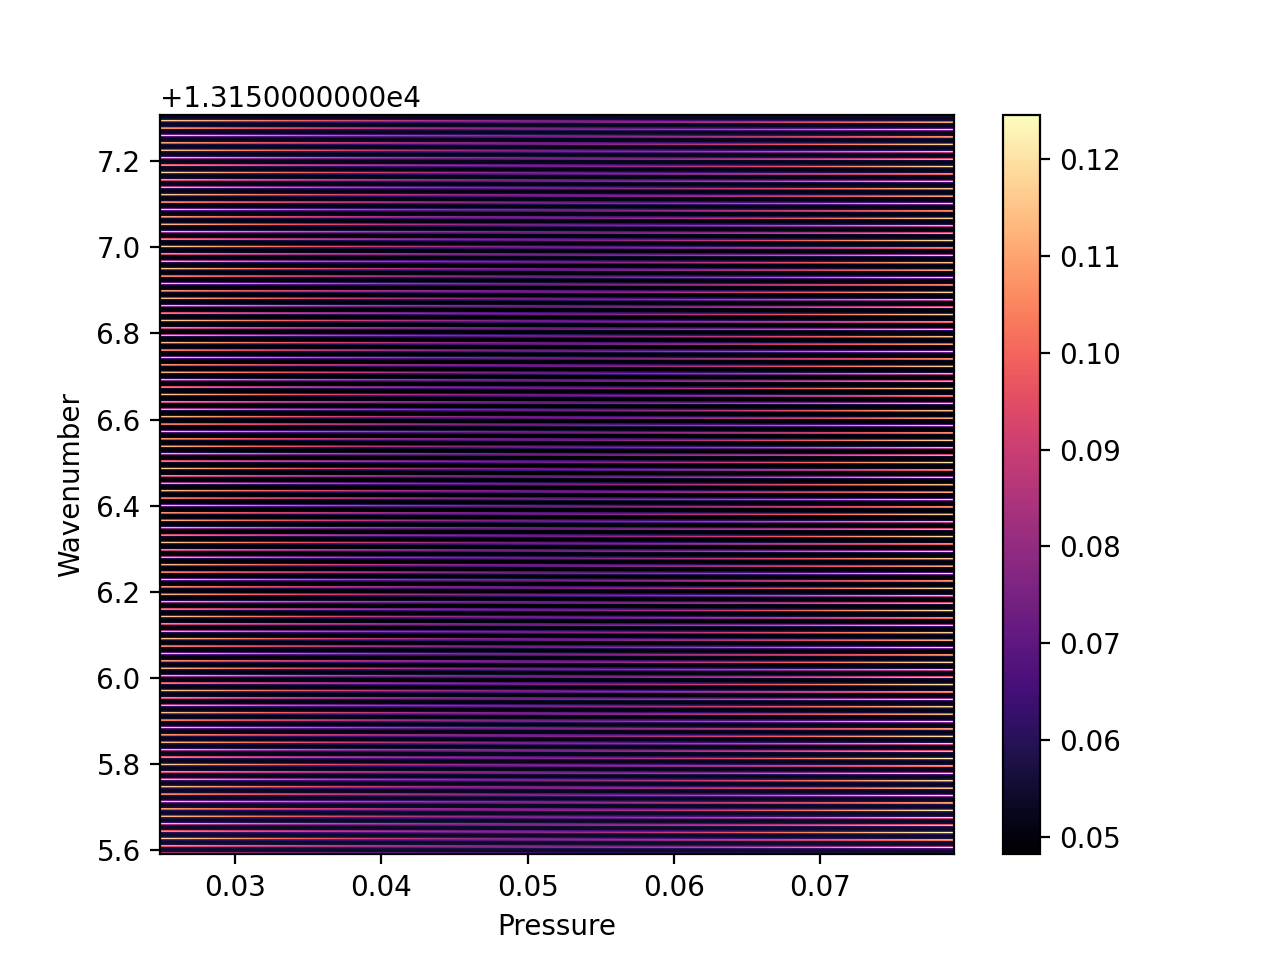

In [32]:
#Can compare to just model uncertainty without adding the learned noise
#If noise is uniform, doesn't matter whether we add it
#But how to pick noise for predictions if noise based on experimental dataset?
#So this is same as above is using VGP, but different if using standard GPR with all datasets
mean, var = gpr.predict_f(xtp_vals)
std = np.sqrt(var.numpy().flatten())
std = np.reshape(std, (x_vals.shape[0], -1))

im = plt.imshow(std, cmap='magma', aspect='auto', origin='lower',
                extent=(p_vals[0], p_vals[-1], x_vals[0], x_vals[-1]))
plt.colorbar(im)
plt.xlabel('Pressure')
plt.ylabel('Wavenumber')
plt.show()

# Multi-line fitting with custom GPR model

In [216]:
from typing import Optional, Tuple

class SwitchedGPR(gpflow.models.GPModel, gpflow.models.InternalDataTrainingLossMixin):
    """Creates GPR with switched likelihood so can have datasets with different variances.
    Avoids needing to use a VGP, which seems to complicate things.
    Y data will need to have a second column to specify which likelihood to use.
    """
    
    def __init__(
        self,
        data: gpflow.models.model.RegressionData,
        kernel: gpflow.kernels.Kernel,
        mean_function: Optional[gpflow.mean_functions.MeanFunction] = None,
        noise_variance: list = [float(1.0)],
    ):
        likelihood = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.Gaussian(variance=v) 
                                                            for v in noise_variance])
        _, Y_data = data
        super().__init__(kernel, likelihood, mean_function, num_latent_gps=Y_data.shape[-1]-1)
        self.data = gpflow.models.util.data_input_to_tensor(data)
        
    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        return self.log_marginal_likelihood()

    def _add_noise_cov(self, K: tf.Tensor) -> tf.Tensor:
        """
        Returns K + σ² I, where σ² is the likelihood noise variance (scalar),
        and I is the corresponding identity matrix.
        """
        k_diag = tf.linalg.diag_part(K)
        
        ind = tf.cast(self.data[1][..., -1], tf.int32)
        like_vars = [tf.convert_to_tensor(l.variance) for l in self.likelihood.likelihoods]
        s_diag = tf.reshape(tf.gather(like_vars, ind), tf.shape(k_diag))
                
        return tf.linalg.set_diag(K, k_diag + s_diag)

    def log_marginal_likelihood(self) -> tf.Tensor:
        r"""
        Computes the log marginal likelihood.

        .. math::
            \log p(Y | \theta).

        """
        X, Y = self.data
        Y = Y[..., :-1]
        K = self.kernel(X)
        ks = self._add_noise_cov(K)
        L = tf.linalg.cholesky(ks)
        m = self.mean_function(X)

        # [R,] log-likelihoods for each independent dimension of Y
        log_prob = gpflow.logdensities.multivariate_normal(Y, m, L)
        return tf.reduce_sum(log_prob)

    def predict_f(
        self, Xnew: gpflow.models.model.InputData, full_cov: bool = False, full_output_cov: bool = False
    ) -> gpflow.models.model.MeanAndVariance:
        r"""
        This method computes predictions at X \in R^{N \x D} input points

        .. math::
            p(F* | Y)

        where F* are points on the GP at new data points, Y are noisy observations at training data points.
        """
        X_data, Y_data = self.data
        Y_data = Y_data[..., :-1]
        err = Y_data - self.mean_function(X_data)

        kmm = self.kernel(X_data)
        knn = self.kernel(Xnew, full_cov=full_cov)
        kmn = self.kernel(X_data, Xnew)
        kmm_plus_s = self._add_noise_cov(kmm)

        conditional = gpflow.conditionals.base_conditional
        f_mean_zero, f_var = conditional(
            kmn, kmm_plus_s, knn, err, full_cov=full_cov, white=False
        )  # [N, P], [N, P] or [P, N, N]
        f_mean = f_mean_zero + self.mean_function(Xnew)
        return f_mean, f_var
    
    

In [217]:
#Now with both peaks!
#And at all pressures!
#And with different noise variance parameters for the different datasets! (see next cell)
#Test out actually fitting some parameters with a GPFlow model
lineshape = LineShapeMulti([7, 7], [1, 1],
                           nu=[13156.28, 13156.62],
                           sw=[4.799, 3.123],
                           elower=[343.75, 440.56],
                           sw_scale_fac=[1e-24, 1e-24],
                           mole_frac=[0.01949, 0.01949],
                           delta0=[-0.007967, -0.008546999999999999],
                           n_delta0=[2.4e-05, 2.8000000000000013e-05],
                           n_gamma0=[0.81, 0.8],
                           n_gamma2=[0.81, 0.8],
                           gamma0=[0.04487, 0.04331], sd_gamma=[0.11240, 0.13064], #These are the optimized values of these parameters from MATS
                           etalons=np.array([[0.00165, 1.271443, -0.734156],
                                             [0.00165, 1.271443, -0.480252],
                                             [0.00165, 1.271443, -1.417825],
                                             [0.00165, 1.271443, -1.647160]])
                          )

#Will only optimize gamma0 and sd_gamma according to example
gpflow.set_trainable(lineshape.nu, False)
gpflow.set_trainable(lineshape.sw, False)
gpflow.set_trainable(lineshape.y, False)
gpflow.set_trainable(lineshape.eta, False)
gpflow.set_trainable(lineshape.sd_delta, False)
gpflow.set_trainable(lineshape.nuVC, False)
gpflow.set_trainable(lineshape.delta0, False)
print(lineshape.trainable_variables)

(<tf.Variable 'gamma0:0' shape=(2,) dtype=float64, numpy=array([0.04487, 0.04331])>, <tf.Variable 'sd_gamma:0' shape=(2,) dtype=float64, numpy=array([0.1124 , 0.13064])>)


In [218]:
gpflow.config.set_default_jitter(1e-06)

kern = gpflow.kernels.SquaredExponential(lengthscales=[1.0, 1.0, 1.0])

test_x = np.vstack(x)
#Add column in y to indicate different likelihoods, i.e., different noise on different experimental datasets
test_y = np.vstack([np.vstack([y[i], np.ones_like(y[i])*i]).T for i in range(len(y))])
print(test_x.shape)
print(test_y.shape)

#Define our Gaussian process regression model
gpr = SwitchedGPR(data=(test_x, test_y),
                  kernel=kern,
                  mean_function=lineshape,
                  noise_variance=[0.01]*len(y))

(928, 3)
(928, 2)


In [219]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
SwitchedGPR.mean_function.nu,Parameter,Identity,,False,"(2,)",float64,[13156.28 13156.62]
SwitchedGPR.mean_function.sw,Parameter,Identity,,False,"(2,)",float64,[4.799 3.123]
SwitchedGPR.mean_function.gamma0,Parameter,Identity,,True,"(2,)",float64,[0.04487 0.04331]
SwitchedGPR.mean_function.delta0,Parameter,Identity,,False,"(2,)",float64,[-0.007967 -0.008547]
SwitchedGPR.mean_function.sd_gamma,Parameter,Identity,,True,"(2,)",float64,[0.1124 0.13064]
SwitchedGPR.mean_function.sd_delta,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
SwitchedGPR.mean_function.nuVC,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
SwitchedGPR.mean_function.eta,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
SwitchedGPR.mean_function.y,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
SwitchedGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0


<IPython.core.display.Javascript object>


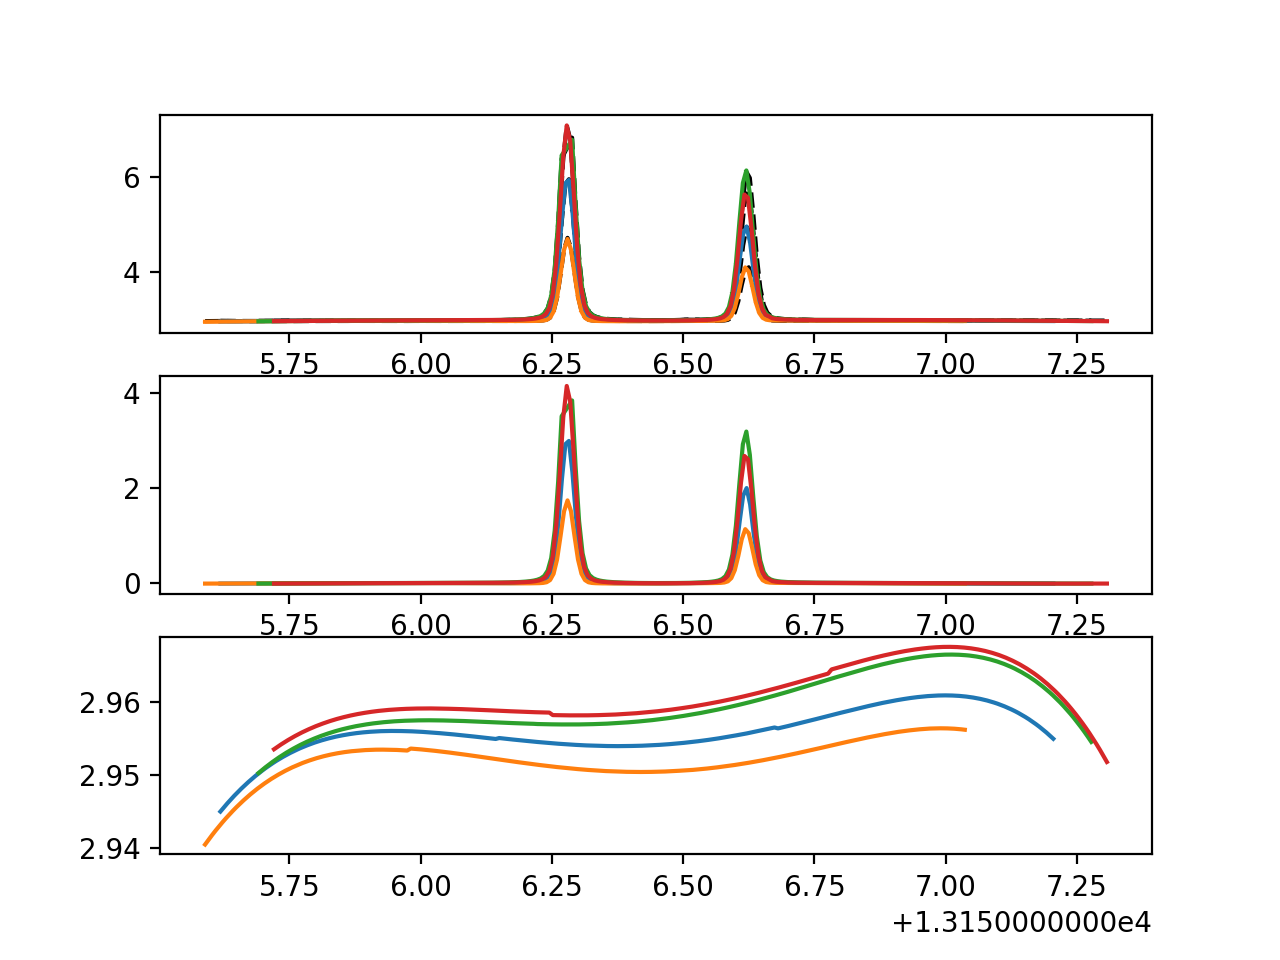

In [220]:
#Predictions before training
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(3)

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    line = lineshape(x[i])
    ax[0].errorbar(x[i][:, 0], mean.numpy(), yerr=np.sqrt(var.numpy().flatten()), color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--')
    ax[1].plot(x[i][:, 0], line.numpy(), color=colors[i])
    ax[2].plot(x[i][:, 0], mean.numpy()-line.numpy(), color=colors[i])

plt.show()

In [222]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=150))

In [223]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
SwitchedGPR.mean_function.nu,Parameter,Identity,,False,"(2,)",float64,[13156.28 13156.62]
SwitchedGPR.mean_function.sw,Parameter,Identity,,False,"(2,)",float64,[4.799 3.123]
SwitchedGPR.mean_function.gamma0,Parameter,Identity,,True,"(2,)",float64,[0.03590754 0.03915753]
SwitchedGPR.mean_function.delta0,Parameter,Identity,,False,"(2,)",float64,[-0.007967 -0.008547]
SwitchedGPR.mean_function.sd_gamma,Parameter,Identity,,True,"(2,)",float64,[1.18189563e-01 2.61657951e-06]
SwitchedGPR.mean_function.sd_delta,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
SwitchedGPR.mean_function.nuVC,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
SwitchedGPR.mean_function.eta,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
SwitchedGPR.mean_function.y,Parameter,Identity,,False,"(2,)",float64,[0. 0.]
SwitchedGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0250138698424323


<IPython.core.display.Javascript object>


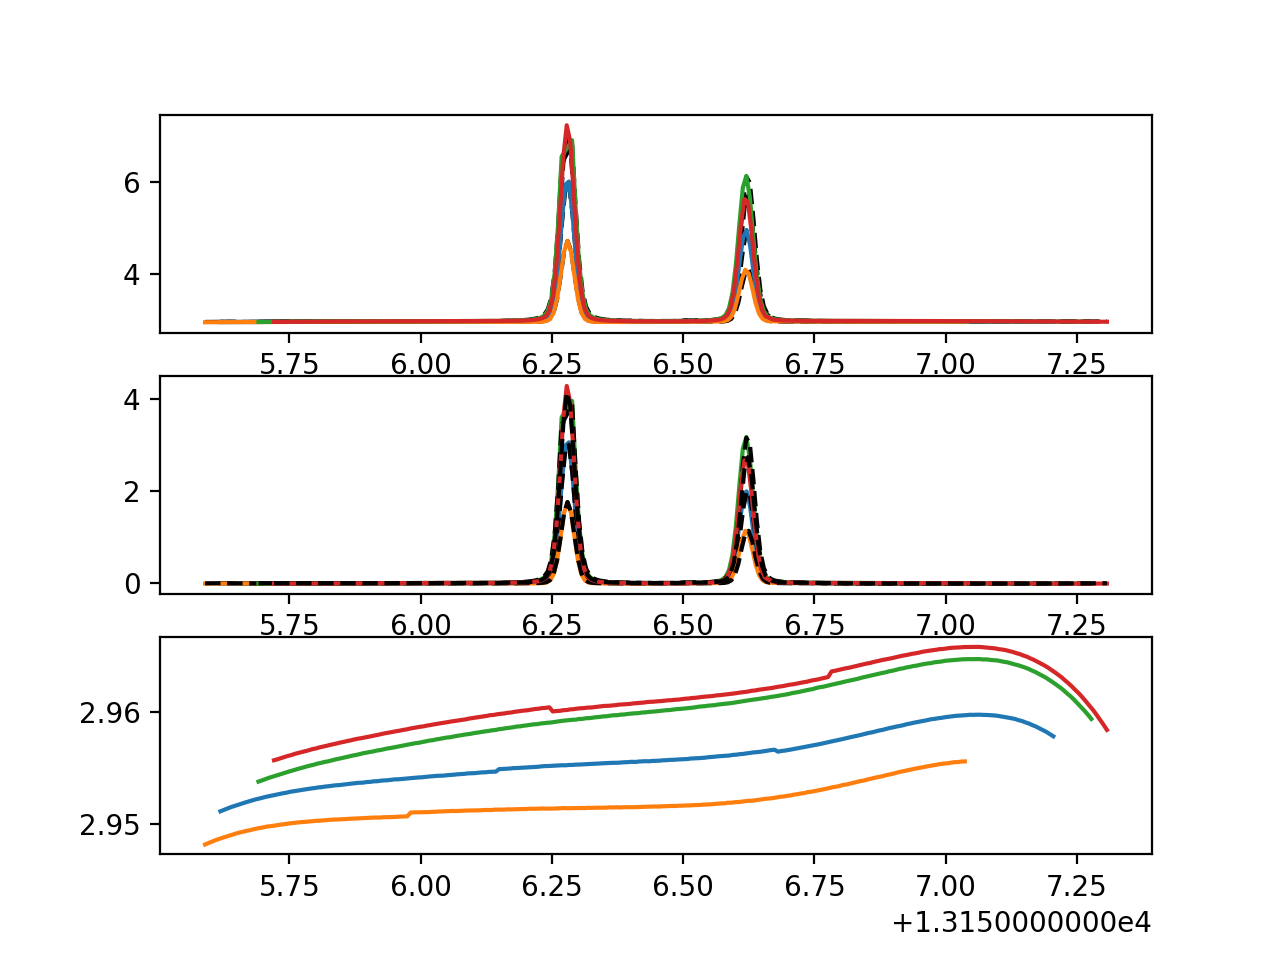

In [224]:
%matplotlib notebook

#And look at predictions from training
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(3)

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    mean = mean[:, 0].numpy()
    var = var[:, 0].numpy()
    line = lineshape(x[i]).numpy().flatten()
    ax[0].errorbar(x[i][:, 0], mean, yerr=np.sqrt(var), color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--')
    ax[1].plot(x[i][:, 0], line, color=colors[i])
    ax[1].plot(x[i][:, 0], y[i] - (mean - line), 'k--')
    ax[2].plot(x[i][:, 0], mean - line, color=colors[i])

plt.show()

<IPython.core.display.Javascript object>


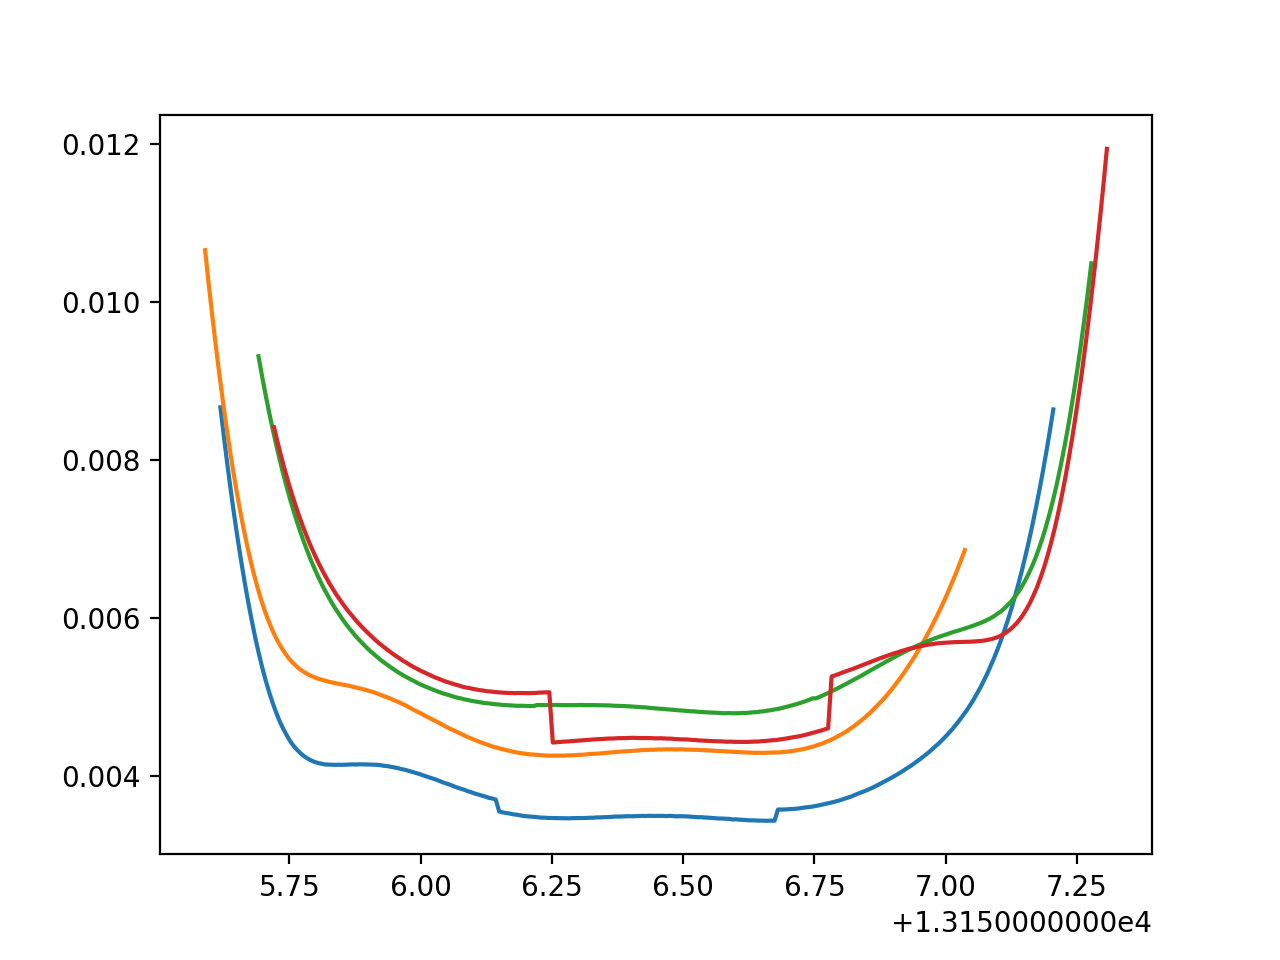

In [225]:
#Examine estimated uncertainty, including estimated noise in data
for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    std = np.sqrt(var[:, 0].numpy().flatten())
    plt.plot(x[i][:, 0], std)

plt.show()

Need to check, but guessing that the places where the uncertainty sharply drops are where the mean function actually produces something other than zero. The mean function does have a cutoff for the minimum intensity, but need to check if this coincides with the discontinuities.

In [226]:
#And if we want to, we can also plot this as a function of both wavenumber AND pressure
#Sort of done above, but above plotted at the input pressures
#We also have model for the uncertainty at unmeasured pressures
p_vals = np.linspace(np.min(test_x[:, 2]), np.max(test_x[:, 2]), 100)
x_vals = np.linspace(np.min(test_x[:, 0]), np.max(test_x[:, 0]), 500)
t_val = np.average(test_x[:, 1])
xtp_vals = []
for p in p_vals:
    xtp_vals.append(np.vstack([x_vals, np.ones_like(x_vals)*t_val, np.ones_like(x_vals)*p]).T)
xtp_vals = np.vstack(xtp_vals)
print(xtp_vals.shape)

(50000, 3)


In [227]:
#Reshape into 2D image
mean, var = gpr.predict_f(xtp_vals)
std = np.sqrt(var.numpy().flatten())
std = np.reshape(std, (x_vals.shape[0], -1))
print(std.shape)

(500, 100)


<IPython.core.display.Javascript object>


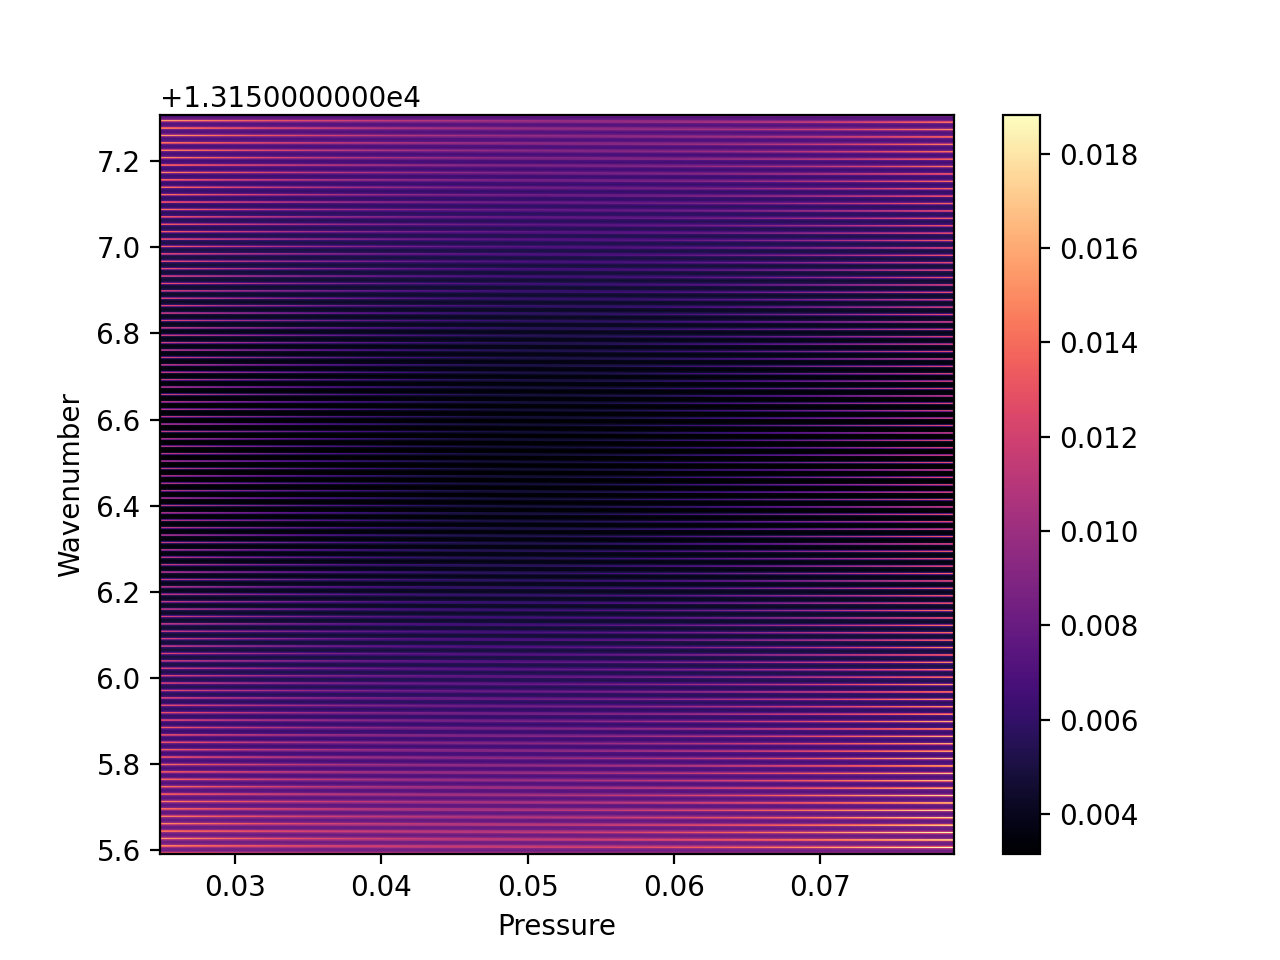

In [228]:
#And plot that image
%matplotlib notebook
im = plt.imshow(std, cmap='magma', aspect='auto', origin='lower',
                extent=(p_vals[0], p_vals[-1], x_vals[0], x_vals[-1]))
plt.colorbar(im)
plt.xlabel('Pressure')
plt.ylabel('Wavenumber')
plt.show()